In [ ]:
import numpy as np
import pandas as pd 
import string
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('drive/MyDrive/MCM2023')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("wordle.csv", encoding='latin-1', skiprows = 1).dropna()
df.columns = ["date", "contest", "word", "number_total", "number_hard", "1_try", "2_try", "3_try", "4_try", "5_try", "6_try", "7_try"]

In [ ]:
with open('allowed_words.txt') as f:
    lines = pd.Series(f.readlines())
words = lines.apply(lambda x : x.split("\n")[0])
word_set = set()
for word in words:
    word_set.add(word)

In [ ]:
#include get_score for orthogonal neighbors
def get_score(word):
    score = 0
    for i in range(5):
        for letter in list(string.ascii_lowercase):
            if letter == word[i]:
                continue
            edited_word = word[0:i] + letter + word[i + 1:]
            if edited_word in word_set:
                score += 1
    return score

def num_letter(word):
    letters = set()
    for letter in word:
        letters.add(letter)
    return len(letters)

def num_consec(word):
    for i in range(1, 5):
        if word[i] == word[i - 1]:
            return 1
    return 0

def has_second_vowel(word):
    return 1 if word[1] in {'a','e', 'i', 'o', 'u'} else 0

def has_third_vowel(word):
    return 1 if word[2] in {'a','e', 'i', 'o', 'u'} else 0

def generate_letter_freq(word):
    freq = {}
    for var in list(string.ascii_lowercase):
        freq[var] = 0
    for c in set(word):
        freq[c] = word.count(c)
    return freq

In [ ]:
def preprocess_data(df):
    df.loc[df["word"] == "favor ","word"] = "favor"
    df.loc[df["word"] == "rprobe","word"] = "probe"
    df.loc[df["word"] == "clen","word"] = "clean"
    df.loc[df["word"] == "tash","word"] = "trash"
    df.loc[df["word"] == "marxh","word"] = "march"
    df.loc[df["contest"] == 540,"word"] = "naive"
    df[df.contest == 281][["1_try","2_try","3_try","4_try","5_try","6_try","7_try"]] = [1,2,18,44,26,9,1]
    df["neighbor"] = df["word"].apply(lambda x : get_score(x))
    df["1_try"] = df["1_try"].astype(float)
    df["2_try"] = df["2_try"].astype(float)
    df["3_try"] = df["3_try"].astype(float)
    df["4_try"] = df["4_try"].astype(float)
    df["5_try"] = df["5_try"].astype(float)
    df["6_try"] = df["6_try"].astype(float)
    df["7_try"] = df["7_try"].astype(float)
    df["mean_try"] = (1 * df["1_try"] + 2*df["2_try"] + 3*df["3_try"] 
                  + 4*df["4_try"] + 5*df["5_try"] + 6*df["6_try"] + 7*df["7_try"])/(df["1_try"] + df["2_try"] + df["3_try"]
                  + df["4_try"] + df["5_try"] + df["6_try"] + df["7_try"])
    
    second_moment = (1 * df["1_try"] + 4*df["2_try"] + 9*df["3_try"] 
                  + 16*df["4_try"] + 25*df["5_try"] + 36*df["6_try"] + 49*df["7_try"])/(df["1_try"] + df["2_try"] + df["3_try"]
                  + df["4_try"] + df["5_try"] + df["6_try"] + df["7_try"])
    
    df["var_try"] = second_moment - df["mean_try"]**2
    df.loc[df["number_total"] < 4000, "number_total"] *= 10
    df["percent_hard"] = df["number_hard"]/df["number_total"]
    df["num_letters"] = df["word"].apply(lambda x : num_letter(x))
    df["consec"] = df["word"].apply(lambda x : num_consec(x))
    df["has2"] = df["word"].apply(lambda x : has_second_vowel(x))
    df["has3"] = df["word"].apply(lambda x : has_third_vowel(x))
    
    df = df.sort_values("contest")
    df.index = range(0, len(df))

    letter_freq = pd.DataFrame(columns = list(string.ascii_lowercase))

    vals = df["word"].apply(lambda x : generate_letter_freq(x)).values.tolist()

    df = pd.concat((df, pd.DataFrame.from_dict(vals)), axis = 1)
    return df

In [ ]:
df = preprocess_data(df)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
hwords = df[df.mean_try > df.mean_try.quantile(0.8)]
ewords = df[df.mean_try < df.mean_try.quantile(0.2)]

def find_avg_placement(word, ind):
    vowels = {"a", "e", "i", "o", "u"}
    return 1 if word[ind] in vowels else 0

lst = []
for i in range(5):
    apply1 = ewords["word"].apply(lambda x : find_avg_placement(x, i)).describe()
    apply1.name = "easy" + str(i + 1)
    apply2 = hwords["word"].apply(lambda x : find_avg_placement(x, i)).describe()
    apply2.name = "hard" + str(i + 1)
    lst.append(apply1)
    lst.append(apply2)
pd.DataFrame(lst)

,count,mean,std,min,25%,50%,75%,max
easy1,72.0,0.083333,0.278325,0.0,0.0,0.0,0.0,1.0
hard1,71.0,0.126761,0.335073,0.0,0.0,0.0,0.0,1.0
easy2,72.0,0.319444,0.469533,0.0,0.0,0.0,1.0,1.0
hard2,71.0,0.718310,0.453025,0.0,0.0,1.0,1.0,1.0
easy3,72.0,0.861111,0.348257,0.0,1.0,1.0,1.0,1.0
hard3,71.0,0.295775,0.459639,0.0,0.0,0.0,1.0,1.0
easy4,72.0,0.277778,0.451046,0.0,0.0,0.0,1.0,1.0
hard4,71.0,0.323944,0.471310,0.0,0.0,0.0,1.0,1.0
easy5,72.0,0.291667,0.457719,0.0,0.0,0.0,1.0,1.0
hard5,71.0,0.267606,0.445862,0.0,0.0,0.0,1.0,1.0


In [ ]:
from scipy import stats
easy2 = ewords["word"].apply(lambda x : find_avg_placement(x, 1))
hard2 = hwords["word"].apply(lambda x : find_avg_placement(x, 1))
print(stats.ttest_ind(easy2, hard2))
easy3 = ewords["word"].apply(lambda x : find_avg_placement(x, 2))
hard3 = hwords["word"].apply(lambda x : find_avg_placement(x, 2))
print(stats.ttest_ind(easy3, hard3))

Ttest_indResult(statistic=-5.168510602521778, pvalue=7.917680625681542e-07)
Ttest_indResult(statistic=8.29731315281169, pvalue=7.737366903130813e-14)


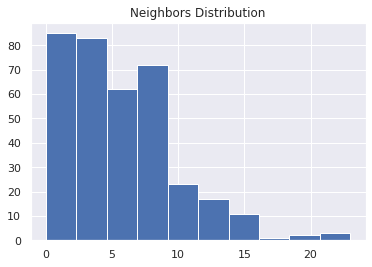

count    359.000000
mean       5.665738
std        4.120357
min        0.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       23.000000
Name: neighbor, dtype: float64


In [ ]:
import seaborn as sns
sns.set_theme()
df["neighbor"].hist()
plt.title("Neighbors Distribution")
plt.show()
print(df["neighbor"].describe())

**Question One**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,plot_predict

In [ ]:
dec = df[40:]

In [ ]:
result = adfuller(df["number_total"][0:40])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.593430
p-value: 0.486893


In [ ]:
result = adfuller(df["number_total"][40:100])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
result

ADF Statistic: -1.708521
p-value: 0.426727


(-1.7085214930397778,
 0.4267273819683297,
 4,
 55,
 {'1%': -3.5552728880540942,
  '5%': -2.9157312396694217,
  '10%': -2.5956695041322315},
 1055.6548700690537)

In [ ]:
df["number_total"].diff().dropna()

1      20873.0
2     -10026.0
3      15657.0
4      46746.0
5     -16294.0
        ...   
354      868.0
355     -719.0
356     -159.0
357     1203.0
358     -824.0
Name: number_total, Length: 358, dtype: float64

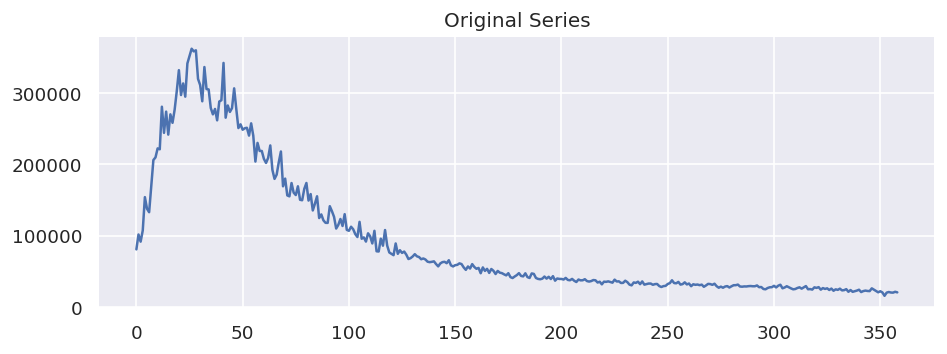

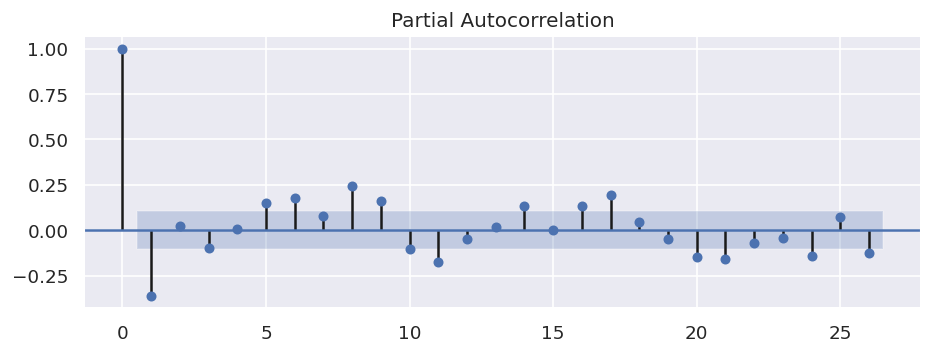

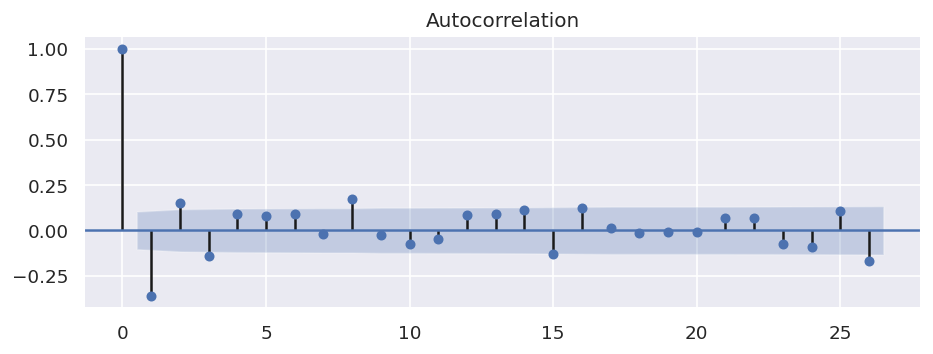

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
dec = df[50:]
plt.plot(df.number_total)
plt.title("Original Series")
plot_pacf(df.number_total.diff().dropna())
plt.show()
plot_acf(df.number_total.diff().dropna())
plt.show()

In [ ]:
model = ARIMA(dec.number_total, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           number_total   No. Observations:                  309
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3205.456
Date:                Sun, 19 Feb 2023   AIC                           6416.912
Time:                        21:49:37   BIC                           6428.103
Sample:                             0   HQIC                          6421.387
                                - 309                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5066      0.063      8.102      0.000       0.384       0.629
ma.L1         -0.6033      0.062     -9.800      0.000      -0.724      -0.483
sigma2      5.225e+07   3.19e-10   1.64e+17      0.0

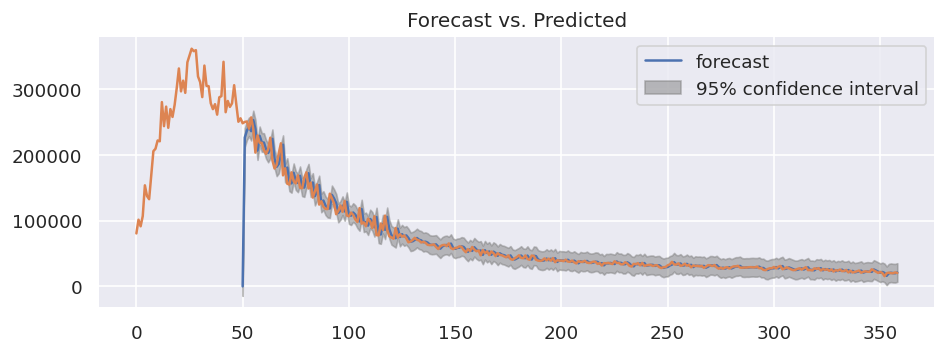

In [ ]:
plot_predict(model_fit)
plt.plot(df["number_total"])
plt.title("Forecast vs. Predicted")
plt.show()

In [ ]:
forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.95)

In [ ]:
yhat_conf_int

,lower number_total,upper number_total
359,19938.585626,20845.101214
360,19787.038610,21008.648357
361,19677.670437,21124.095984
362,19587.311495,21217.534873
363,19507.923914,21298.482804
364,19435.862029,21371.335187
365,19369.182758,21438.414937
366,19306.719753,21501.080831
367,19247.705252,21560.198119
368,19191.596682,21616.358762


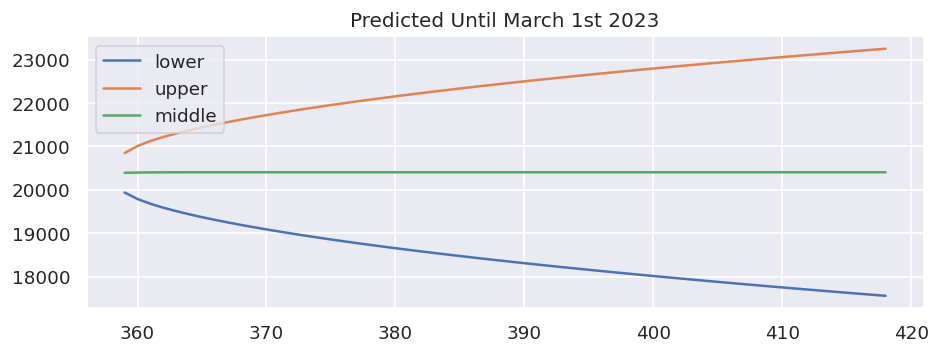

In [ ]:
plt.plot(yhat_conf_int)
plt.plot(yhat)
plt.legend(["lower", "upper", "middle"])
plt.title("Predicted Until March 1st 2023")
plt.show()

In [ ]:
df["number_trend"] = model_fit.fittedvalues

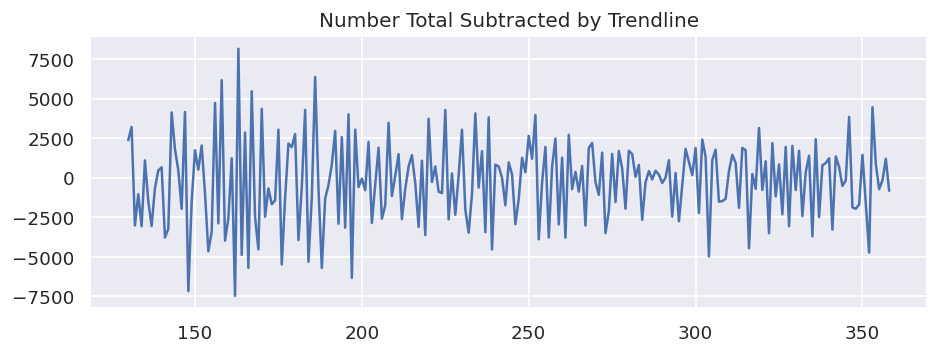

In [ ]:
df["normal_number"] = df["number_total"].diff()

plt.plot(df["normal_number"][130:])
plt.title("Number Total Subtracted by Trendline")
plt.show()

In [ ]:
dec = df[70:]

In [ ]:
dec[["normal_number", "percent_hard"]].corr()

,normal_number,percent_hard
normal_number,1.000000,0.046871
percent_hard,0.046871,1.000000


In [ ]:
dec[["normal_number", "mean_try"]].corr()

,normal_number,mean_try
normal_number,1.0000,-0.2964
mean_try,-0.2964,1.0000


In [ ]:
import statsmodels.api as sm
X = dec[["percent_hard", "mean_try"]]
y = dec["normal_number"]
X = sm.add_constant(X)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          normal_number   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     14.63
Date:                Sun, 19 Feb 2023   Prob (F-statistic):           8.89e-07
Time:                        21:49:39   Log-Likelihood:                -2936.2
No. Observations:                 289   AIC:                             5878.
Df Residuals:                     286   BIC:                             5889.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.684e+04   4430.540      3.800   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Problem Two**

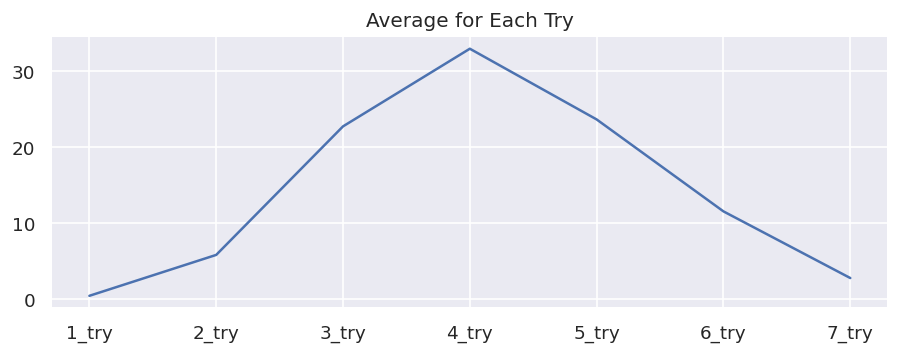

In [ ]:
plt.plot(df[["1_try", "2_try", "3_try","4_try", "5_try", "6_try", "7_try"]].mean())
plt.title("Average for Each Try")
plt.show()

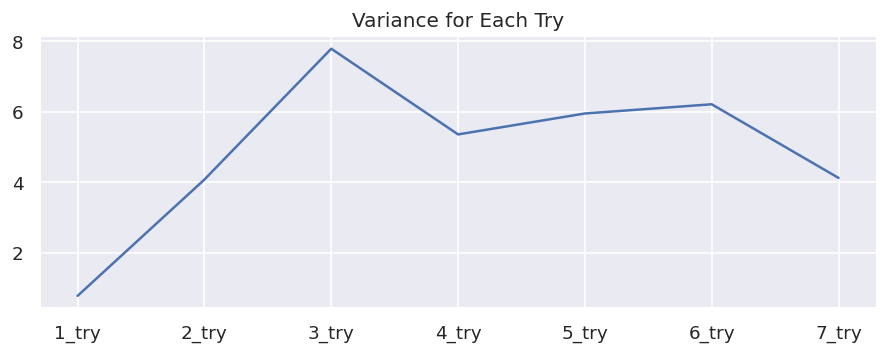

In [ ]:
plt.plot(df[["1_try", "2_try", "3_try","4_try", "5_try", "6_try", "7_try"]].std())
plt.title("Variance for Each Try")
plt.show()

In [ ]:
from scipy import stats
#checking to see if normality assumptions matter by adding Gaussian noise to existing data
non_normal = 0

for val in df[["1_try", "2_try", "3_try", "4_try", "5_try", "6_try", "7_try"]].iterrows():
  values = list(val[1])
  find_data = np.array([])
  for i in range(7):
    find_data = np.append(find_data, np.repeat(i+1, int(values[i])).astype(float) + np.random.random(int(values[i])) * 0.5)
  
  k2, p = stats.normaltest(find_data)
  if p < 0.05:
    non_normal += 1
non_normal/len(df)

0.05013927576601671

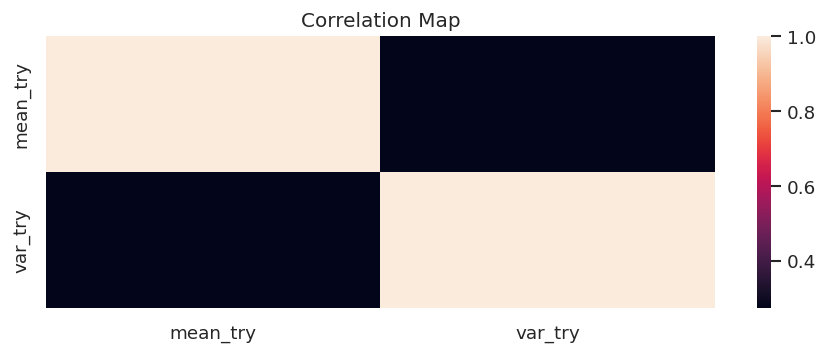

In [ ]:
import seaborn as sns
sns.heatmap(df[["mean_try", "var_try"]].corr())
plt.title("Correlation Map")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
#linear modeling to finding mean and var of the try for a normal distribution fitting
X = df[["num_letters","consec", "neighbor","has2", "has3", *list(string.ascii_lowercase)]]
y1 = df["mean_try"]
y2 = df["var_try"]
y3 = df["6_try"] + df["7_try"]
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.2)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
print(mean_squared_error(y_pred, y_test))

0.5964407738066455
0.059869213352353214


In [ ]:
model = LassoCV(cv = 4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
print(mean_squared_error(y_pred, y_test))

0.6004048582630409
0.05928112961479304


In [ ]:
model = RidgeCV(cv = 4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
print(mean_squared_error(y_pred, y_test))

0.5975319298767809
0.05970733709894711


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.2, random_state = 13123)

X = df[["num_letters","consec", "neighbor","has2", "has3", *list(string.ascii_lowercase)]]
RidgeModelMean = RidgeCV(cv = 4)
RidgeModelMean.fit(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size = 0.2, random_state = 13123)

RidgeModelVar= RidgeCV(cv = 4)
RidgeModelVar.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=4)

In [ ]:
from scipy.stats import norm
from scipy.special import rel_entr

def normalize(x, mean, var):
    return (x - mean)/(np.sqrt(var))

def create_feature(word):
  X = df[["num_letters","consec", "neighbor","has2", "has3", *list(string.ascii_lowercase)]]
  num_letters = num_letter(word)
  consec = num_consec(word)
  neighbor = get_score(word)
  has2 = has_second_vowel(word)
  has3 = has_third_vowel(word)
  freq_dict = generate_letter_freq(word)
  features = np.array([num_letters, consec, neighbor, has2, has3, *freq_dict.values()])
  col_name = X.columns
  data = pd.DataFrame(columns = X.columns)
  data.loc[0] = features
  return data

def create_distribution(mean, var):
  bucket_1 = (norm.cdf(normalize(1.5, mean, var)))
  bucket_2 = (norm.cdf(normalize(2.5, mean, var)) - norm.cdf(normalize(1.5, mean, var)))
  bucket_3 = (norm.cdf(normalize(3.5, mean, var)) - norm.cdf(normalize(2.5, mean, var)))

  bucket_4 = (norm.cdf(normalize(4.5, mean, var)) - norm.cdf(normalize(3.5, mean, var)))
  bucket_5 = (norm.cdf(normalize(5.5, mean, var)) - norm.cdf(normalize(4.5, mean, var)))
  bucket_6 = (norm.cdf(normalize(6.5, mean, var)) - norm.cdf(normalize(5.5, mean, var)))
  bucket_7 = (1 - norm.cdf(normalize(6.5, mean, var)))

  if isinstance(bucket_1, np.ndarray ):
    return [bucket_1[0], bucket_2[0], bucket_3[0], bucket_4[0], bucket_5[0], bucket_6[0], bucket_7[0]]

  return [bucket_1, bucket_2, bucket_3, bucket_4, bucket_5, bucket_6, bucket_7]

def generate_pred(word):
  feature = create_feature(word)
  mean1 = RidgeModelMean.predict(feature)
  var1 = RidgeModelVar.predict(feature)
  return create_distribution(mean1, var1)

In [ ]:
div = []
mean_div = []
mean_no_normal_div = []

for val in df.loc[X_test.index][["word", "1_try", "2_try", "3_try", "4_try", "5_try", "6_try", "7_try"]].iterrows():
  word = list(val[1])[0]
  actual_dist = list(val[1][1:]/val[1][1:].sum())
  pred_dist = generate_pred(word)
  mean_dist = create_distribution(df.loc[X_test.index]["mean_try"].mean(), df.loc[X_test.index]["var_try"].mean())
  mean_no_normal = list(df.loc[X_test.index][["1_try", "2_try", "3_try","4_try", "5_try", "6_try", "7_try"]].mean())
  mean_no_normal = [x/sum(mean_no_normal) for x in mean_no_normal]

  kl = 0
  for i in range(len(actual_dist)):
    if pred_dist[i] > 0.01 and actual_dist[i] > 0.01:
      kl += actual_dist[i] * np.log(actual_dist[i] / pred_dist[i])
  div.append(kl)
  kl = 0
  for i in range(len(actual_dist)):
    if mean_dist[i] > 0.01 and actual_dist[i] > 0.01:
      kl += actual_dist[i] * np.log(actual_dist[i] / mean_dist[i])
  mean_div.append(kl)

  kl = 0
  for i in range(len(actual_dist)):
    if mean_no_normal[i] > 0.01 and actual_dist[i] > 0.01:
      kl += actual_dist[i] * np.log(actual_dist[i] / mean_no_normal[i])
  mean_no_normal_div.append(kl)
  
sum(div)/len(div), sum(mean_div) / len(mean_div), sum(mean_no_normal_div) / len(mean_no_normal_div)

(0.04506556865921065, 0.0646093279494801, 0.05767984147506819)

In [ ]:
len(X_train), len(X_test)

(287, 72)

**Problem 3**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection

In [ ]:
from sklearn.cluster import SpectralClustering, KMeans

In [ ]:
X = df[["1_try","2_try", "3_try", "4_try", "5_try", "6_try", "7_try"]]

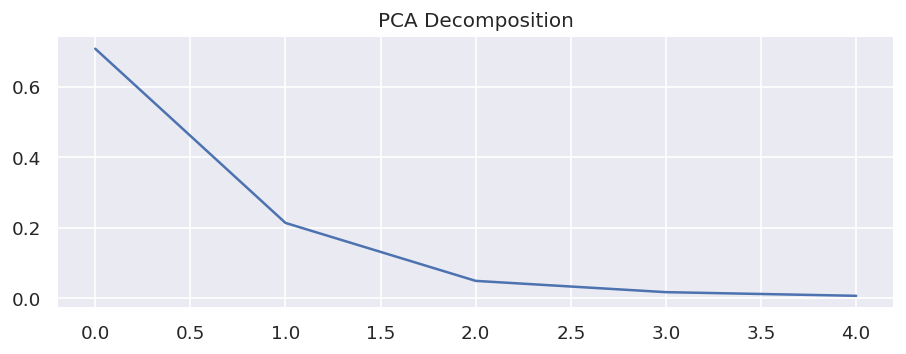

In [ ]:
pca = PCA(n_components=5)
pca.fit(X)
plt.plot(pca.explained_variance_ratio_)
plt.title("PCA Decomposition")
plt.show()

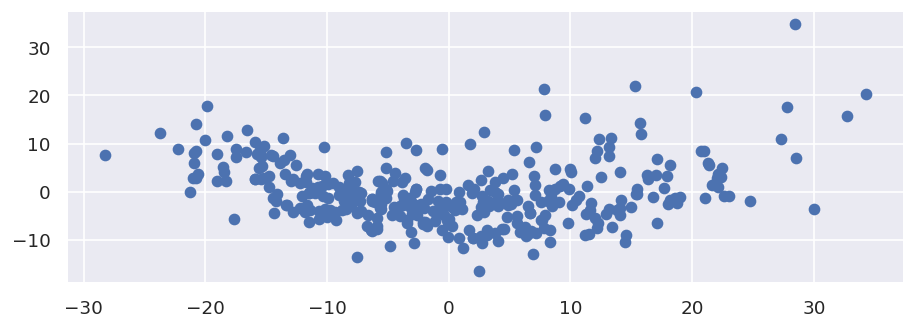

In [ ]:
pca = PCA(n_components=2)
transformed_x = pca.fit_transform(X)

plt.scatter(transformed_x[:, 0],transformed_x[:, 1])
use_kmeans = True
rating = None

if use_kmeans:
  kmeans = KMeans(n_clusters=3).fit(transformed_x)
  rating = kmeans.predict(transformed_x)
else:
  rating = SpectralClustering(n_clusters=3, assign_labels='discretize').fit_predict(transformed_x)
df["rating"] = rating

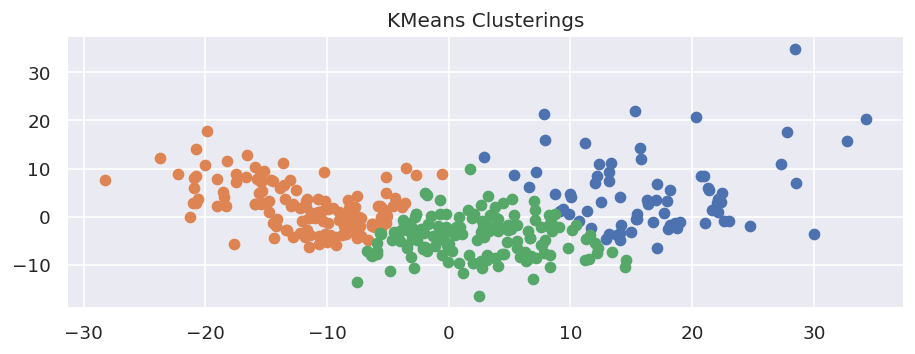

In [ ]:
rating = rating.reshape(-1, 1)
val = np.append(transformed_x, rating, axis = 1)
data = pd.DataFrame(val, columns = ["x1", "x2", "label"])

filtered_0 = data[data.label == 0]
plt.scatter(filtered_0["x1"] , filtered_0["x2"])

filtered_1 = data[data.label == 1]
plt.scatter(filtered_1["x1"] , filtered_1["x2"])

filtered_2 = data[data.label == 2]
plt.scatter(filtered_2["x1"] , filtered_2["x2"])
plt.title("KMeans Clusterings")
plt.show()

In [ ]:
columns = ['percent_hard', 'num_letters', 'consec', 'has2','has3','mean_try','1_try',
       '2_try', '3_try', '4_try', '5_try', '6_try', '7_try', 'neighbor']
for val in columns:
  group = df.groupby("rating")[val].describe()
  print(val + " " +str(round(group.iloc[0, 1], 3))  + " " + str(round(group.iloc[1, 1], 3)) + " " + str(round(group.iloc[2, 1], 3)))

percent_hard 0.073 0.075 0.077
num_letters 4.466 4.902 4.647
consec 0.178 0.03 0.144
has2 0.712 0.376 0.425
has3 0.342 0.684 0.516
mean_try 4.755 3.815 4.254
1_try 0.288 0.805 0.268
2_try 2.877 9.489 4.092
3_try 12.808 30.827 20.418
4_try 25.986 33.654 35.608
5_try 28.863 17.737 26.275
6_try 21.329 6.383 11.399
7_try 7.781 1.068 1.941
neighbor 7.479 5.647 4.817


In [ ]:
generate_pred("eerie")

[0.002075745263609951,
 0.02443562070223142,
 0.13140554417811934,
 0.3136322055769905,
 0.33363995979425415,
 0.1582430832472037,
 0.03656784123759094]